In [1]:
import json

documents = []
document_ratings = []
count = 0

with open('Amazon.json', 'r') as f:
    for line in f:
        if count < 250000:
            try:
                entry = json.loads(line)
                review = entry.get('text')
                rating = entry.get('rating')
                if len(review.split()) > 10:
                    count += 1
                    documents.append(review)
                    document_ratings.append(rating)
            except json.JSONDecodeError:
                continue  # skip malformed lines
        else:
            break

In [ ]:
documents

In [2]:
len(documents)

250000

In [3]:
f = open("documents.txt", "w")

print(documents, file=f)

f.close()

In [3]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .6,
                            min_df = 100)
td_matrix = vectorizer.fit_transform([x for x in documents])

In [6]:
print(type(td_matrix))
print(td_matrix.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(250000, 4316)


In [ ]:
%pip install scipy

In [7]:
import scipy
from scipy.sparse.linalg import svds
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u, s, v_trans = svds(td_matrix, k=100)

In [8]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(250000, 100)
(100,)
(100, 4316)


In [10]:
%pip install matplotlib
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


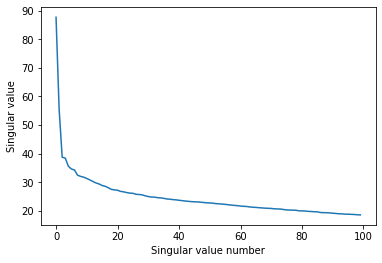

In [9]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [10]:
#      U       sigma       V^T
docs_compressed, s, words_compressed = svds(td_matrix, k=50)
words_compressed = words_compressed.transpose()

In [11]:
print(words_compressed.shape)
print(docs_compressed.shape)

(4316, 50)
(250000, 50)


In [12]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}

#row normalize
from sklearn.preprocessing import normalize
words_compressed_normed = normalize(words_compressed, axis = 1)

# cosine similarity
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

td_matrix_np = td_matrix.transpose().toarray()
td_matrix_np = normalize(td_matrix_np)

In [14]:
word = 'chic'
print("Using SVD:")
for w, sim in closest_words(word, words_compressed_normed):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()
#print("Without using SVD: using term-doc matrix directly:")
#for w, sim in closest_words(word, td_matrix_np):
#  try:
#    print("{}, {:.3f}".format(w, sim))
#  except:
#    print("word not found")
#print()

Using SVD:
sophisticated, 0.769
matte, 0.768
polished, 0.761
vintage, 0.758
embellishments, 0.752
fashion, 0.748
subtle, 0.737
boho, 0.737
vibe, 0.736
eye, 0.734



In [15]:
docs_compressed_normed = normalize(docs_compressed)

# this is basically the same cosine similarity code that we used before, just with some changes to
# the returned output format to let us print out the documents in a sensible way
def closest_docs(doc_index_in, doc_repr_in, k = 5):
    sims = doc_repr_in.dot(doc_repr_in[doc_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(documents[i],sims[i]) for i in asort[1:]]

# Once again, basically the same cosine similarity code, but mixing two different matrices
def closest_docs_to_word(word_in, k = 5):
    if word_in not in word_to_index: return "Not in vocab."
    sims = docs_compressed_normed.dot(words_compressed_normed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(i, documents[i],sims[i]) for i in asort[1:]]

In [16]:
for i, doc, sim in closest_docs_to_word("bargain"):
    print("({}, {}, {:.4f}".format(i, doc, sim))

(99770, Lightweight, breath well, plenty of cushion, fair price.  New Balance at it's best., 0.8893
(126095, terrible price for some white underwear ! never will purchase again due to the cost.., 0.8868
(225781, Gorgeous and best price around - found these for $100 more at a local retailer., 0.8835
(243866, Get lots of laughs and the price and shipping were excellent., 0.8796
(89193, Cutest show for awesome price! Couldn’t be happier with my purchase!, 0.8773


In [17]:
query = "party dress"
query_tfidf = vectorizer.transform([query]).toarray()
query_tfidf.shape

(1, 4316)

In [18]:
query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()
query_vec.shape

(50,)

In [19]:
def closest_docs_to_query(query_vec_in, k = 5):
    sims = docs_compressed_normed.dot(query_vec_in)
    asort = np.argsort(-sims)[:k+1]
    return [(i, documents[i],sims[i]) for i in asort[1:]]

for i, doc, sim in closest_docs_to_query(query_vec):
    print("({}, {}, {:.4f}".format(i, doc, sim))

(244592, So refreshing to put this dress on and go to some friends cookout, 0.9936
(149983, Dress is see through and my under garments can be seen, 0.9931
(174088, I Went To Church With This Wonderful Dress, So Many Comments!!, 0.9912
(54051, I chose this as my mother of the groom dress. It was stunning., 0.9899
(241097, And importantly it is lined. You can dress it up with heels or dress it down with a flip flop., 0.9899


In [19]:
for i in range(50):
    print("Top words in dimension", i)
    dimension_col = words_compressed[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:10]])
    print()

Top words in dimension 0
['big', 'long', 'light', 'earrings', 'super', 'weight', 'old', 'expected', 'large', 'year']

Top words in dimension 1
['shoe', 'buy', 'time', 'large', 'expected', 'look', 'recommend', 'got', 'thought', 'jacket']

Top words in dimension 2
['price', 'long', 'time', 'ordered', 'old', 'year', 'bought', 'soft', 'expected', 'happy']

Top words in dimension 3
['got', 'colors', 'looks', 'compliments', 'expected', 'husband', 'super', 'happy', 'comfy', 'wallet']

Top words in dimension 4
['looks', 'big', 'buy', 'soft', 'expected', 'way', 'perfect', 'look', 'hat', 'boots']

Top words in dimension 5
['long', 'buy', 'loves', 'time', 'feet', 'super', 'bag', 'comfy', 'boots', 'length']

Top words in dimension 6
['expected', 'gift', 'colors', 'shorts', 'loved', 'fabric', 'long', 'like', 'ordered', 'light']

Top words in dimension 7
['got', 'bag', 'long', 'loved', 'big', 'fits', 'perfectly', 'quality', 'old', 'shorts']

Top words in dimension 8
['price', 'expected', 'bag', 'bra

In [20]:
docs_compressed_normed

array([[-0.05712544,  0.08108019,  0.093178  , ...,  0.01351381,
         0.10032322, -0.1444049 ],
       [ 0.07979067,  0.13710227, -0.19384757, ...,  0.11549934,
         0.17086275, -0.21025229],
       [ 0.17007726,  0.03217325,  0.07851378, ..., -0.28545005,
         0.18846378, -0.19528776],
       ...,
       [ 0.08409716,  0.2351125 , -0.17670408, ..., -0.20759504,
         0.086183  , -0.08119134],
       [-0.02402887, -0.01840428,  0.00538204, ...,  0.08541252,
         0.06139807, -0.08374709],
       [-0.064016  , -0.16738548, -0.02095376, ...,  0.0851267 ,
         0.07496238, -0.09508865]])